### Imports

In [2]:
%load_ext autoreload
%autoreload 2

import random

import torch
from torch_geometric.loader import DataLoader
from data_utils import *
from tqdm import tqdm
import pandas as pd

import networkx as nx
import torch_geometric.utils as pyg_utils

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

from graph_vae.vae import GraphVAE

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Dataset

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
include_hydrogen = False

prop_norm_df = create_or_load_property_norm_df()

properties = ["homo", "lumo", "r2"]

# create dataset and dataloaders
dataset = create_qm9_graph_vae_dataset(
    device=device, 
    include_hydrogen=False, 
    refresh_data_cache=False,
    properties=properties,
    prop_norm_df=prop_norm_df
)

_, val_dataset, _ = create_qm9_data_split(dataset=dataset)

batch_size = 1024
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
full_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

print(f"Validation set size = {len(val_dataset)}")

Validation set size = 12805


### Load Models

In [4]:
# model without property prediction
model = GraphVAE.from_pretrained("./checkpoints/graph_vae_20240531_010935.pt").to(device)
model.eval()

# model with property prediction
model_prop = GraphVAE.from_pretrained("./checkpoints/graph_vae_20240531_022759.pt").to(device)
model_prop.eval()

# model with property prediction and latent splitting
model_prop_split = GraphVAE.from_pretrained("./checkpoints/graph_vae_20240531_035329.pt").to(device)
model_prop_split.eval()

print()

### Kernel Density Estimate of the Latent Variables

In [4]:
def plot_latent_kde(model: GraphVAE, val_loader: DataLoader):
    """ Plot a kernel density estimate of the distribution of ~5000 encoded validation molecules along each dimension of the latent space. """

    z_list = []
    num_molecules = 0
    for batch in tqdm(val_loader):
        with torch.no_grad():
            z = model.encode(batch)
        z_list.append(z)
        num_molecules += len(batch)

    z = torch.concat(z_list, dim=0).detach().cpu()

    latent_dim = model.latent_dim
    for dim in tqdm(range(z.shape[1])):
        sns.kdeplot(z[:, dim], legend=False, color=sns.color_palette("husl", latent_dim)[dim])
    
    # plt.title(f'KDE of each latent dimension (n={latent_dim})')
    plt.gca().set_ylabel('')
    plt.show()

 46%|████▌     | 46/101 [00:01<00:02, 24.83it/s]

100%|██████████| 128/128 [00:16<00:00,  7.66it/s]


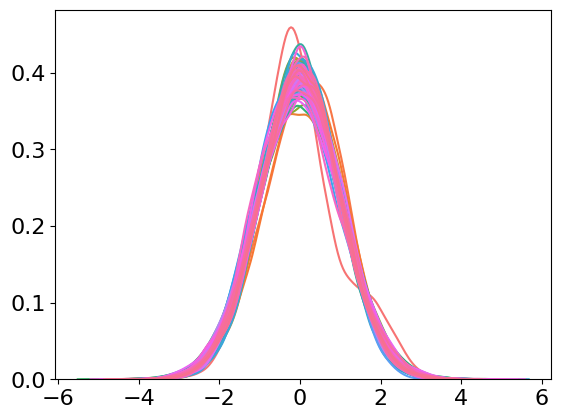

In [23]:
# without property prediction
plot_latent_kde(model=model, val_loader=val_loader)

  1%|          | 1/101 [00:00<00:14,  6.72it/s]

100%|██████████| 128/128 [00:16<00:00,  7.65it/s]


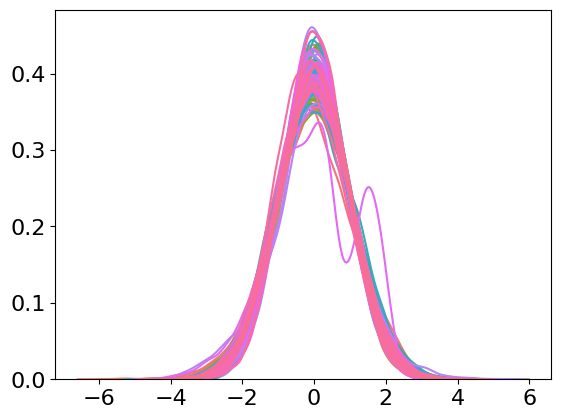

In [24]:
# with property prediction
plot_latent_kde(model_prop, val_loader)

  6%|▌         | 6/101 [00:00<00:03, 24.45it/s]

100%|██████████| 128/128 [00:16<00:00,  7.90it/s]


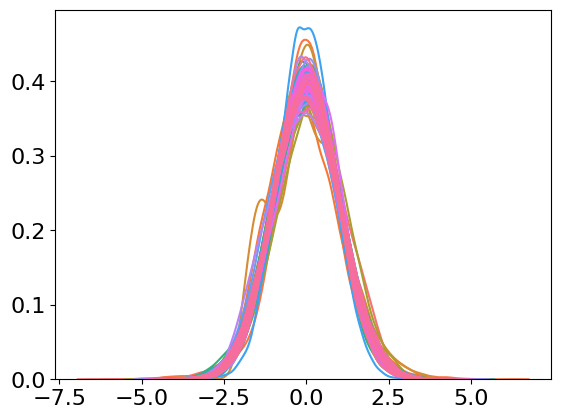

In [25]:
# with property prediction
plot_latent_kde(model_prop_split, val_loader)

### Latent PCA Plots

In [15]:
# without property prediction
def plot_latent_pca(model: GraphVAE, loader: DataLoader):
    z_list = []
    y_list = []
    for batch in tqdm(loader):
        with torch.no_grad():
            z_list.append(model.z_to_property_z(model.encode_mean(batch)))
            y_list.append(model_prop.denormalize_properties(batch.y))

    z = torch.cat(z_list, dim=0).detach().cpu().numpy()
    y = torch.cat(y_list, dim=0).detach().cpu().numpy()

    z_pca = PCA(n_components=2).fit_transform(z)
    z_pca = MinMaxScaler().fit_transform(z_pca)

    for index, property in enumerate(properties):
        scatter = plt.scatter(x= z_pca[:, 0], y=z_pca[:,1], c=y[:, index],
                    cmap= 'viridis', marker='.',
                    s=10,alpha=0.5, edgecolors='none')
        plt.colorbar(scatter, label=property.upper())
        plt.show()

  2%|▏         | 19/1001 [00:00<00:40, 24.34it/s]

100%|██████████| 1001/1001 [00:40<00:00, 24.61it/s]


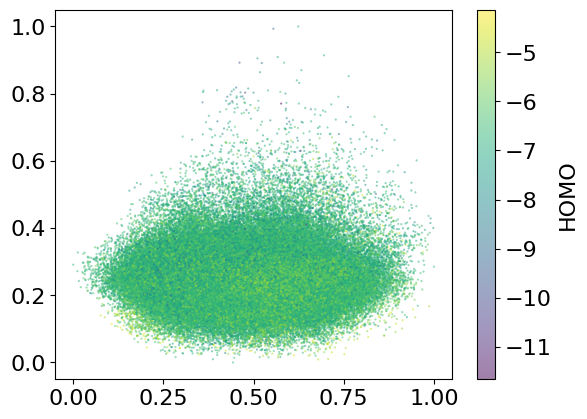

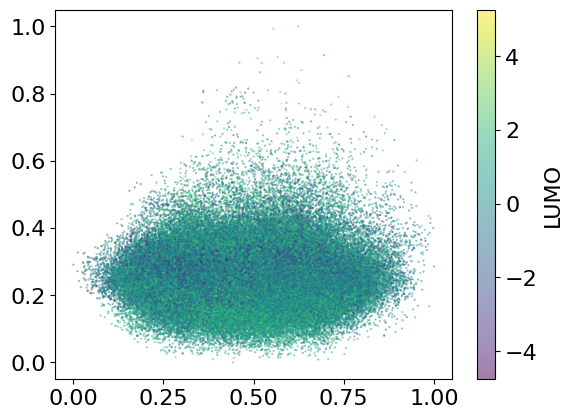

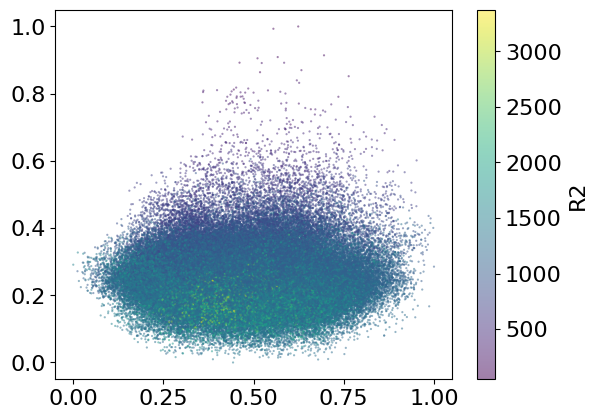

In [16]:
# model without property prediction
plot_latent_pca(model=model, loader=full_loader)

  2%|▏         | 21/1001 [00:00<00:40, 24.22it/s]

100%|██████████| 1001/1001 [00:40<00:00, 24.80it/s]


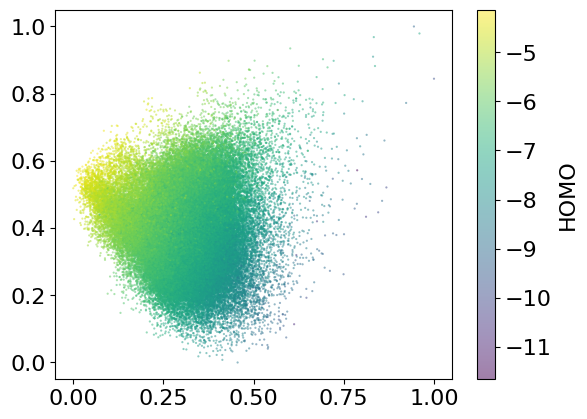

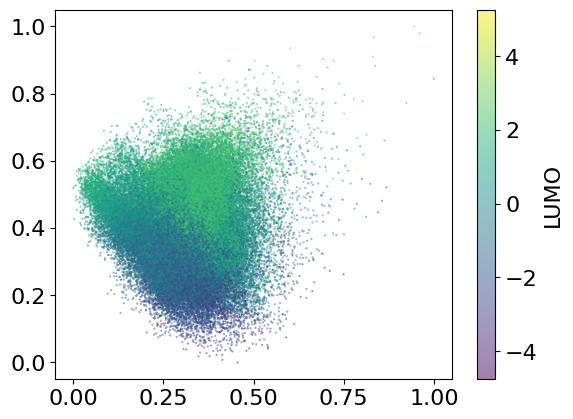

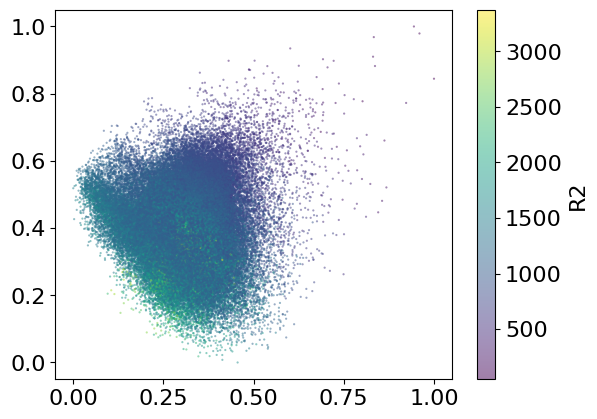

In [17]:
# model with property prediction
plot_latent_pca(model=model_prop, loader=full_loader)

  4%|▎         | 36/1001 [00:01<00:38, 24.91it/s]

100%|██████████| 1001/1001 [00:39<00:00, 25.07it/s]


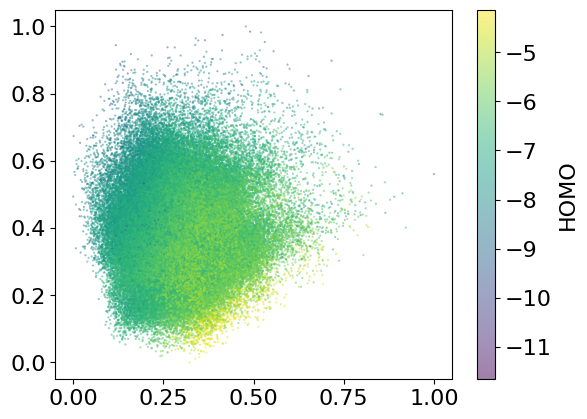

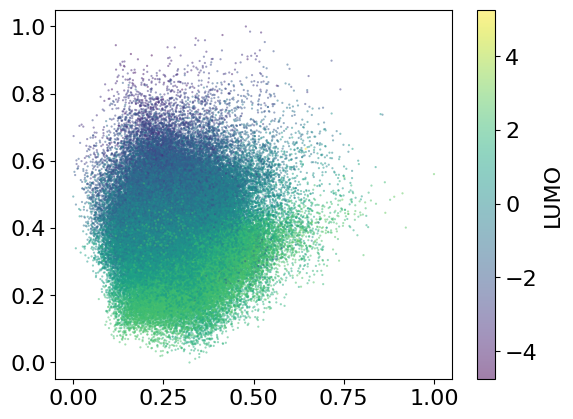

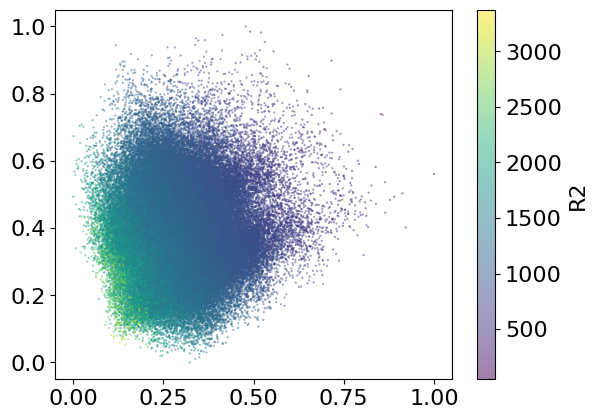

In [18]:
# model with property prediction and latent splitting
plot_latent_pca(model=model_prop_split, loader=full_loader)

### Latent Interpolation

In [38]:
def slerp(val, low, high):
    """Spherical linear interpolation."""
    low_norm = low / torch.norm(low, dim=-1, keepdim=True)
    high_norm = high / torch.norm(high, dim=-1, keepdim=True)
    
    dot_product = torch.clamp(torch.sum(low_norm * high_norm, dim=-1), -1.0, 1.0)
    omega = torch.acos(dot_product)
    so = torch.sin(omega)
    
    if torch.any(so < 1e-6):
        # linear interpolation for cases where the vectors are almost the same or opposite
        return (1.0 - val) * low + val * high
    
    return (torch.sin((1.0 - val) * omega) / so).unsqueeze(-1) * low + (torch.sin(val * omega) / so).unsqueeze(-1) * high


def plot_latent_interpolation(start_index: int, end_index: int, val_loader: DataLoader, model: GraphVAE):

    print(f"Start Index = {start_index}")
    print(f"End Index = {end_index}")

    with torch.no_grad():

        val_batch = next(iter(val_loader))

        z = model.encode_mean(val_batch)

        z_start = z[start_index].unsqueeze(0)
        z_end = z[end_index].unsqueeze(0)

        num_steps = 8
        _, axs = plt.subplots(1, num_steps, figsize=(20, 20))
        axs = axs.flatten()

        for i in range(num_steps):
            f = i / (num_steps - 1)
            z_interpolated = slerp(f, z_start, z_end)

            recon = model.decode(z_interpolated)
            
            x = (recon[0], recon[1], recon[2])

            # plot start- and endpoint encoder input molecules
            if i == 0:
                graph = val_batch[start_index]
            elif i == num_steps - 1:
                graph = val_batch[end_index]
            else:
                graph = model.output_to_graph(x=x, stochastic=False)

            is_valid = True
            if not nx.is_connected(pyg_utils.to_networkx(graph, to_undirected=True)):
                is_valid = False

            try:
                mol = graph_to_mol(data=graph, includes_h=include_hydrogen, validate=True)
            except Exception as e:
                is_valid = False
                print(e)

            mol_img = mol_to_image_tensor(mol=mol).transpose(1, 3).transpose(1, 2)
            axs[i].imshow(mol_img[0])
            # title = "Valid" if is_valid else "Invalid"
            # axs[i].set_title(title)
            axs[i].axis("off")

    plt.tight_layout()
    plt.show()

Start Index = 971
End Index = 550


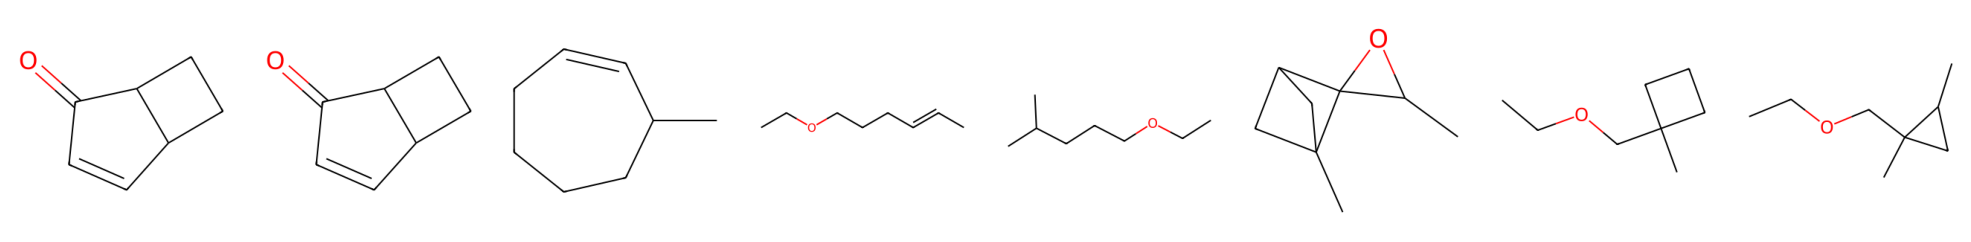

In [39]:
# fix the random seed
random.seed(12)
start_index = random.randrange(0, batch_size)
end_index = random.randrange(0, batch_size)
plot_latent_interpolation(start_index=start_index, end_index=end_index, val_loader=val_loader, model=model)

Start Index = 593
End Index = 171


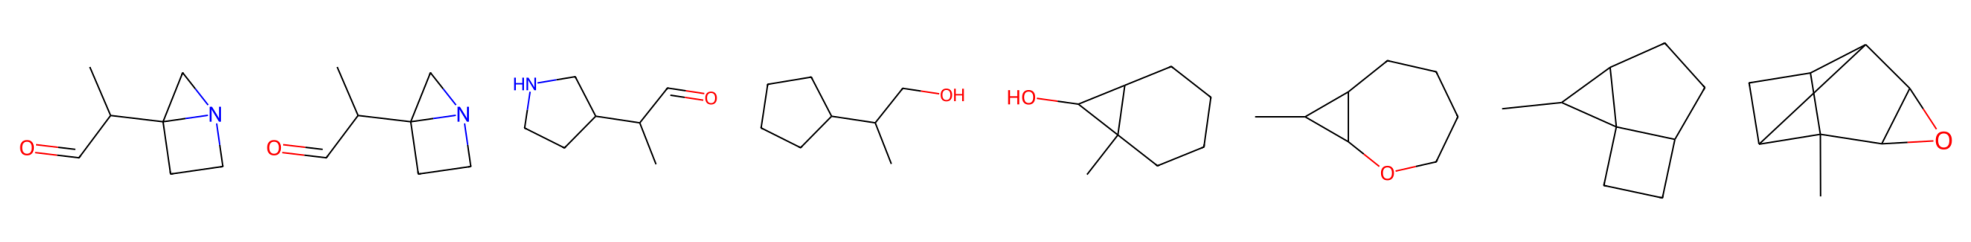

In [40]:
# fix the random seed
random.seed(23)
start_index = random.randrange(0, batch_size)
end_index = random.randrange(0, batch_size)
plot_latent_interpolation(start_index=start_index, end_index=end_index, val_loader=val_loader, model=model)

Start Index = 228
End Index = 51


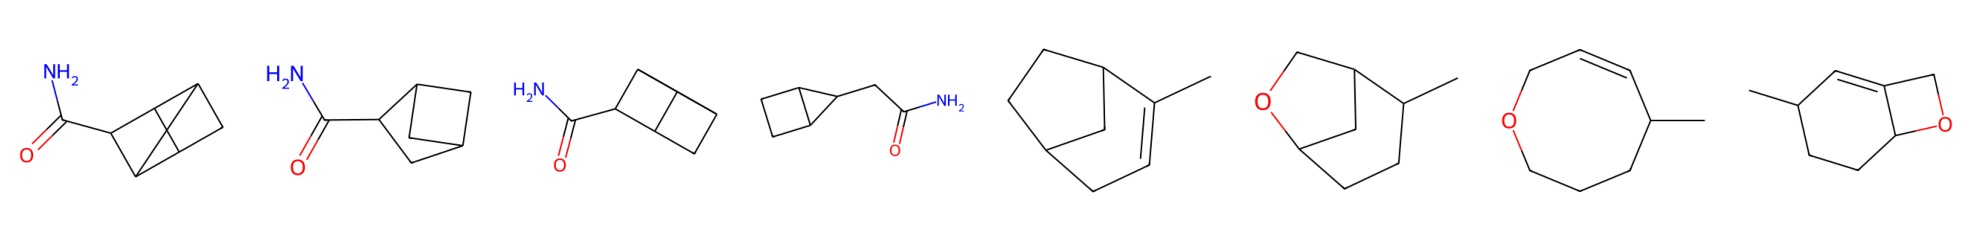

In [41]:
# fix the random seed
random.seed(42)
start_index = random.randrange(0, batch_size)
end_index = random.randrange(0, batch_size)
plot_latent_interpolation(start_index=start_index, end_index=end_index, val_loader=val_loader, model=model)

Start Index = 556
End Index = 855


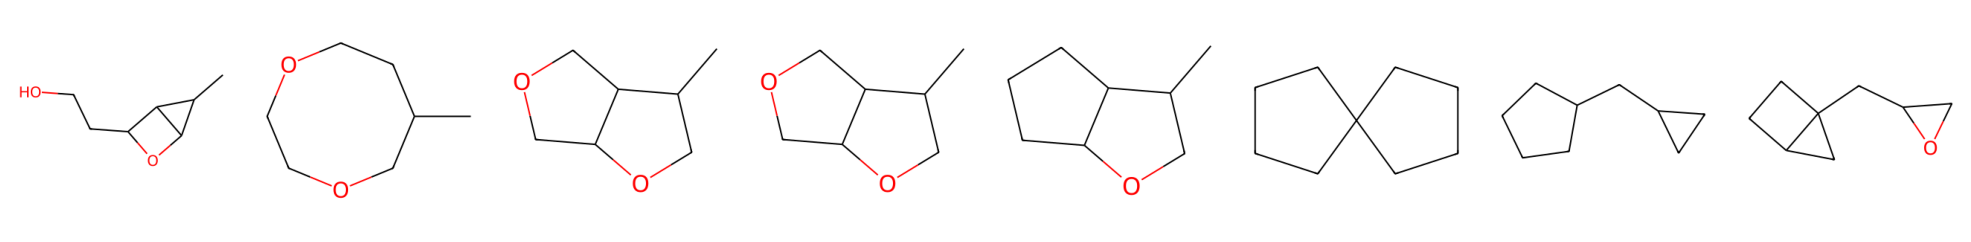

In [42]:
# fix the random seed
random.seed(45)
start_index = random.randrange(0, batch_size)
end_index = random.randrange(0, batch_size)
plot_latent_interpolation(start_index=start_index, end_index=end_index, val_loader=val_loader, model=model)

Start Index = 297
End Index = 896


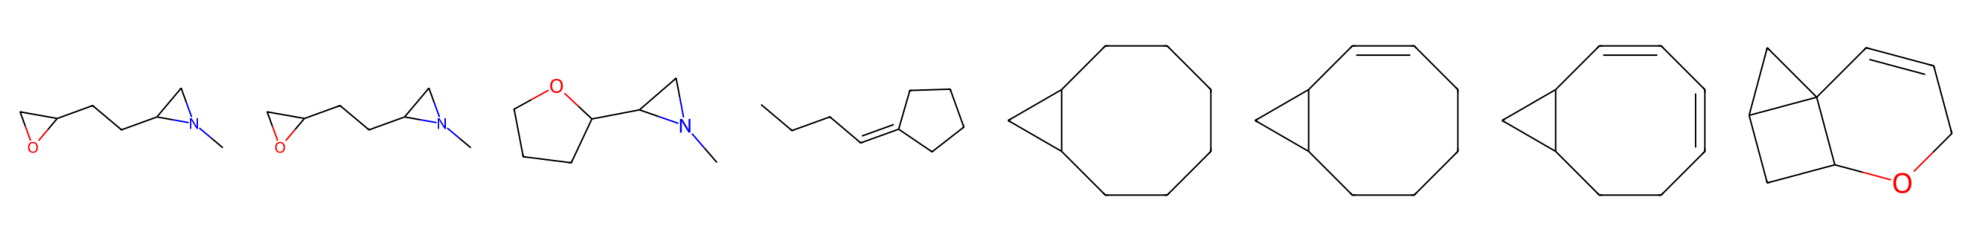

In [43]:
# fix the random seed
random.seed(79)
start_index = random.randrange(0, batch_size)
end_index = random.randrange(0, batch_size)
plot_latent_interpolation(start_index=start_index, end_index=end_index, val_loader=val_loader, model=model)

### Posterior Distribution: Encode-Decode

In [6]:
#8, 190, 59, 101
mol_index = 59

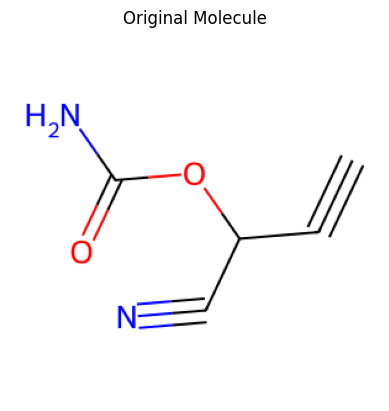

In [7]:
src_mol_graph = val_dataset[mol_index]
src_mol = graph_to_mol(src_mol_graph, includes_h=False, validate=False)
src_mol_img = mol_to_image_tensor(src_mol).transpose(1, 3).transpose(1, 2)
plt.imshow(src_mol_img[0])
plt.title("Original Molecule")
plt.axis("off")
plt.show()
z = graph_vae_model.encode(src_mol_graph)

  0%|          | 0/1000 [00:00<?, ?it/s]

Input SMILES: [H]C#C[C@@]([H])(C#N)OC(=O)N([H])[H]


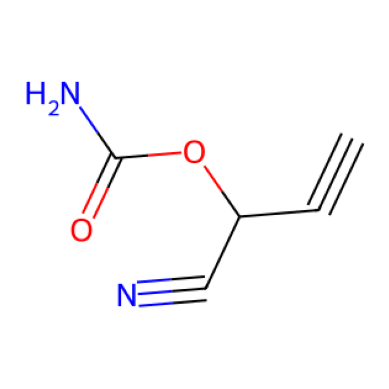

100%|██████████| 1000/1000 [01:05<00:00, 15.23it/s]

Decoded 996 valid molecules.
Decoded 9 unique molecules


In [9]:
val_loader = dataloaders["val"]

input_mol_index = mol_index
decode_count = 1000

decoded_mols = dict()
valid_count = 0

for i in tqdm(range(decode_count)):
    with torch.no_grad():

        val_batch = next(iter(val_loader))

        if i == 0:
            print(f"Input SMILES: {val_batch[input_mol_index].smiles}")

            input_mol = graph_to_mol(data=val_batch[input_mol_index], includes_h=include_hydrogen, validate=False)
            input_mol_img = mol_to_image_tensor(mol=input_mol).transpose(1, 3).transpose(1, 2)
            plt.imshow(input_mol_img[0])
            #plt.title("Input Molecule")
            plt.axis("off")
            plt.show()

        # TODO: encode 100 times and decode stochastically
        z = graph_vae_model.encode(val_batch)
        val_recon = graph_vae_model.decode(z[input_mol_index].unsqueeze(0))
        
        x = (val_recon[0], val_recon[1], val_recon[2])
        recon_graph = graph_vae_model.output_to_graph(x=x, stochastic=False)

        if not nx.is_connected(pyg_utils.to_networkx(recon_graph, to_undirected=True)):
            continue

        try:
            recon_mol = graph_to_mol(data=recon_graph, includes_h=include_hydrogen, validate=True)
        except:
            continue

        valid_count += 1

        smiles = Chem.MolToSmiles(recon_mol)
        if smiles not in decoded_mols:
            decoded_mols[smiles] = (recon_mol, 1)
        else:
            _, count = decoded_mols[smiles]
            count += 1
            decoded_mols[smiles] = (recon_mol, count)

print(f"Decoded {valid_count} valid molecules.")
print(f"Decoded {len(decoded_mols)} unique molecules")

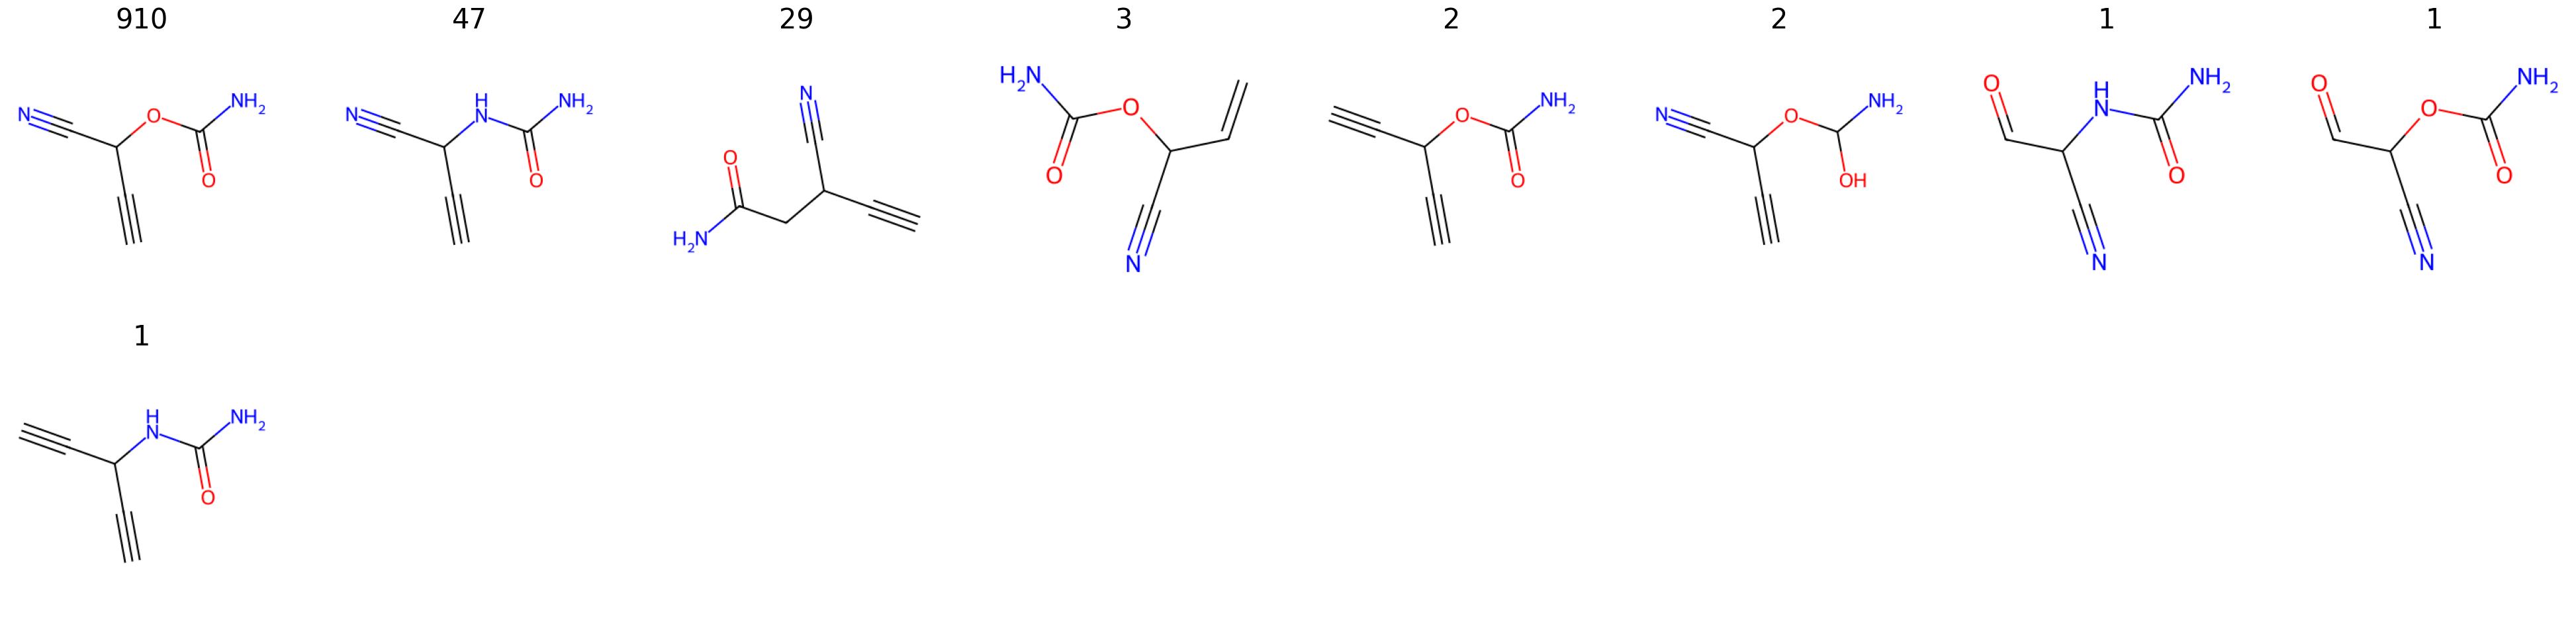

In [10]:
num_mols = min(32, len(decoded_mols))

num_cols = 8
num_rows = (num_mols + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 5))
fig.tight_layout(pad=3.0)

# Flatten the axes array for easy indexing
axes = axes.flatten()

smiles_list = []
mol_list = []
count_list = []
for smiles, (mol, count) in decoded_mols.items():
    smiles_list.append(smiles)
    mol_list.append(mol)
    count_list.append(count)

df = pd.DataFrame({"smiles": smiles_list, "mol": mol_list, "count": count_list})
df.sort_values(by="count", ascending=False, inplace=True)

for i, (index, row) in enumerate(df.head(num_mols).iterrows()):
    mol = row["mol"]
    count = row["count"]

    mol_img = mol_to_image_tensor(mol=mol).transpose(1, 3).transpose(1, 2)
    ax = axes[i]
    ax.imshow(mol_img[0])
    ax.set_title(f"{count}", fontsize=30)
    ax.axis("off")


# # If the number of molecules is not a perfect fill for the subplot grid, hide the extra subplots
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.show()


### Latent Interpolation

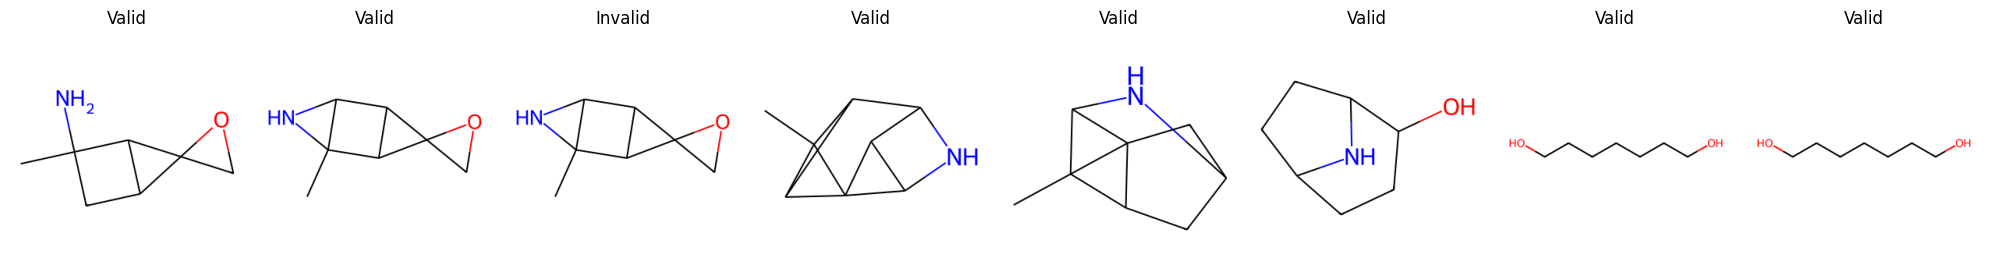

In [15]:
import random
from scipy.spatial import geometric_slerp


def slerp(z_0, z_1, fraction):
    sphere_center = 0.5 * z_0 + 0.5 * z_1

    start_mol_z = z_0 - sphere_center
    end_mol_z = z_1 - sphere_center

    norm_scale = np.linalg.norm(start_mol_z)
    assert np.linalg.norm(start_mol_z) - np.linalg.norm(end_mol_z) < 0.0001

    start_mol_z /= norm_scale
    end_mol_z /= norm_scale

    assert np.linalg.norm(start_mol_z) - 1 < 0.000001
    assert np.linalg.norm(end_mol_z) - 1 < 0.000001

    z_slerped = geometric_slerp(start_mol_z, end_mol_z, fraction)
    z_slerped = z_slerped * norm_scale + sphere_center

    return z_slerped


val_loader = dataloaders["val"]

start_index = random.randint(0, 255)
end_index = random.randint(0, 255)

print(f"Start index: {start_index}")
print(f"End index = {end_index}")

with torch.no_grad():

    val_batch = next(iter(val_loader))

    z = graph_vae_model.encode(val_batch)

    z_start = z[start_index].unsqueeze(0)
    z_end = z[end_index].unsqueeze(0)


    num_steps = 8
    cols = num_steps
    rows = 1
    fig, axs = plt.subplots(rows, cols, figsize=(20, 20))  # Adjust figsize to suit your needs
    axs = axs.flatten()  # Flatten the array of axes to make them easier to index

    for i in range(num_steps):
        f = i / (num_steps - 1)
        z_interpolated = (1 - f) * z_start + f * z_end
        #z_interpolated = slerp(z_start[0].cpu(), z_end[0].cpu(), f)

        recon = graph_vae_model.decode(z_interpolated)
        
        x = (recon[0], recon[1], recon[2])
        graph = graph_vae_model.output_to_graph(x=x, stochastic=False)

        is_valid = True
        if not nx.is_connected(pyg_utils.to_networkx(graph, to_undirected=True)):
            is_valid = False

        try:
            mol = graph_to_mol(data=graph, includes_h=include_hydrogen, validate=True)
        except:
            is_valid = False

        mol_img = mol_to_image_tensor(mol=mol).transpose(1, 3).transpose(1, 2)
        axs[i].imshow(mol_img[0])
        title = "Valid" if is_valid else "Invalid"
        axs[i].set_title(title)
        axs[i].axis("off")

plt.tight_layout()
plt.show()

### Decoding Distribution Histogram

- Encode a molecule to its latent mean and decode stochastically.


  0%|          | 0/1000 [00:00<?, ?it/s]

Input SMILES: [H]C1([H])C(=O)O[C@@]1([H])C#CC#N


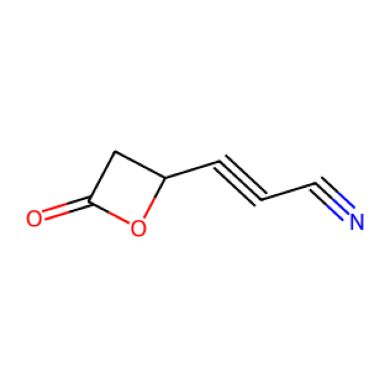

100%|██████████| 1000/1000 [00:02<00:00, 337.25it/s]


Decoded 936 valid molecules.
Decoded 9 unique molecules


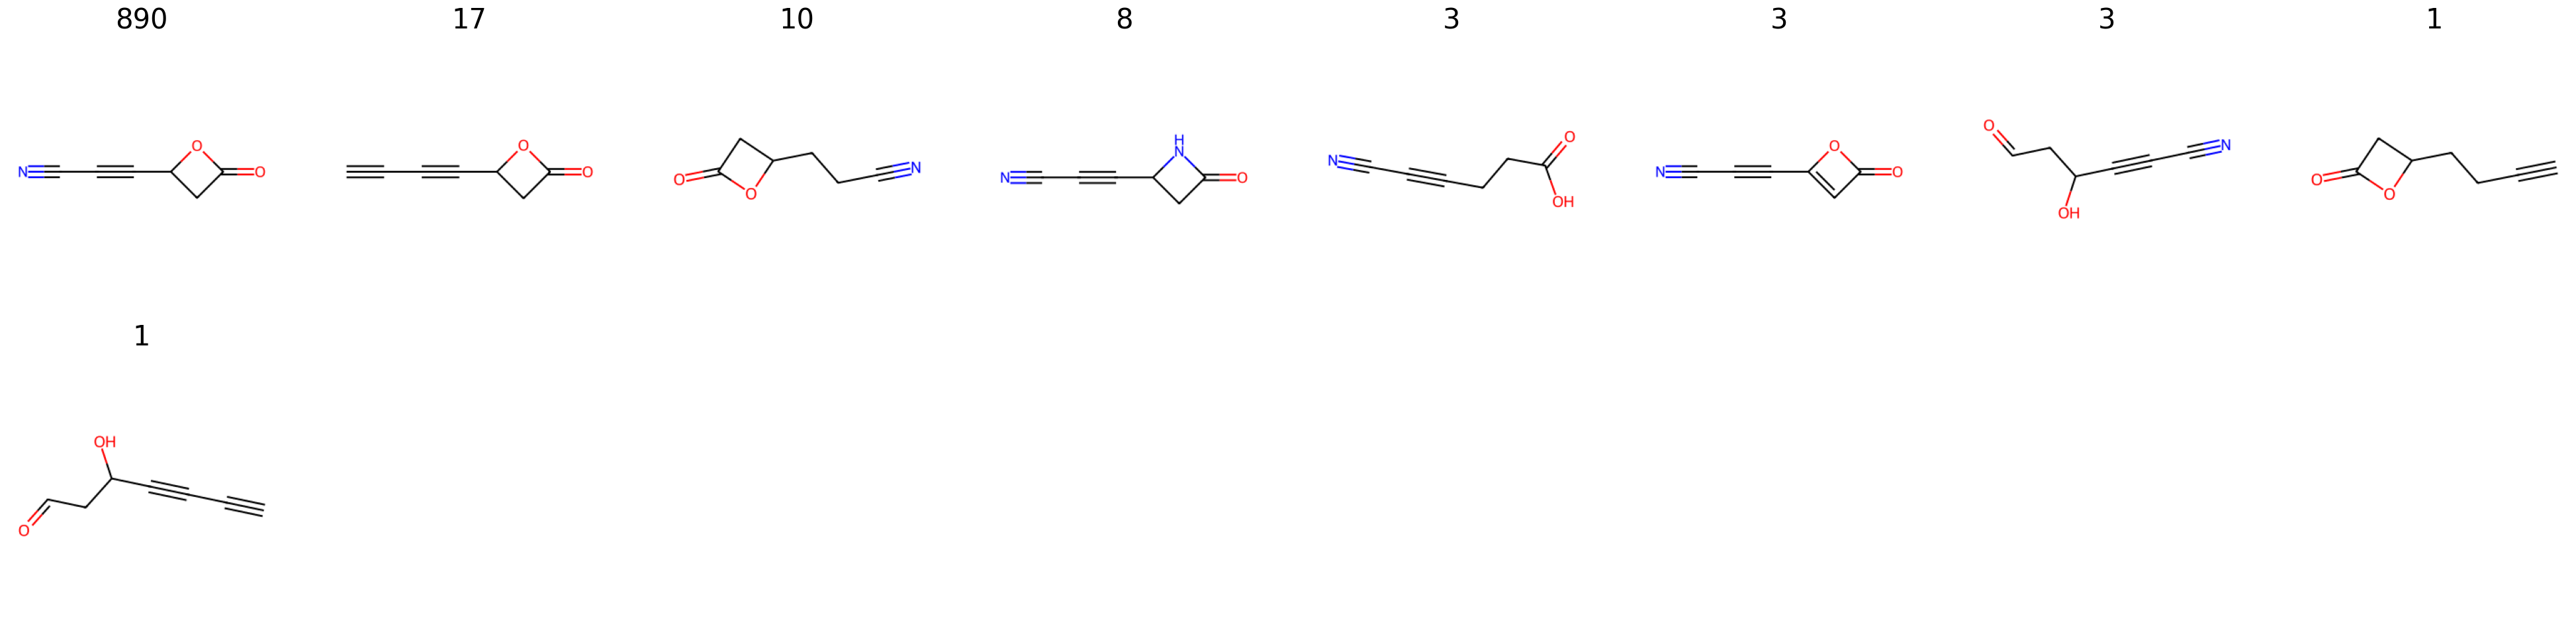

In [31]:
#8, 190, 59, 101
mol_index = 101


input_mol_index = mol_index
decode_count = 1000

decoded_mols = dict()
valid_count = 0

val_batch = next(iter(val_loader))
z = graph_vae_model.encode_mean(val_batch)[input_mol_index].unsqueeze(0)

for i in tqdm(range(decode_count)):
    with torch.no_grad():

        if i == 0:
            print(f"Input SMILES: {val_batch[input_mol_index].smiles}")

            input_mol = graph_to_mol(data=val_batch[input_mol_index], includes_h=include_hydrogen, validate=False)
            input_mol_img = mol_to_image_tensor(mol=input_mol).transpose(1, 3).transpose(1, 2)
            plt.imshow(input_mol_img[0])
            #plt.title("Input Molecule")
            plt.axis("off")
            plt.show()

        val_recon = graph_vae_model.decode(z)
        
        x = (val_recon[0], val_recon[1], val_recon[2])
        recon_graph = graph_vae_model.output_to_graph(x=x, stochastic=True)

        if not nx.is_connected(pyg_utils.to_networkx(recon_graph, to_undirected=True)):
            continue

        try:
            recon_mol = graph_to_mol(data=recon_graph, includes_h=include_hydrogen, validate=True)
        except:
            continue

        valid_count += 1

        smiles = Chem.MolToSmiles(recon_mol)
        if smiles not in decoded_mols:
            decoded_mols[smiles] = (recon_mol, 1)
        else:
            _, count = decoded_mols[smiles]
            count += 1
            decoded_mols[smiles] = (recon_mol, count)

print(f"Decoded {valid_count} valid molecules.")
print(f"Decoded {len(decoded_mols)} unique molecules")


num_mols = min(32, len(decoded_mols))

num_cols = min(8, num_mols)
num_rows = (num_mols + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 5))
fig.tight_layout(pad=3.0)

# Flatten the axes array for easy indexing
if num_mols > 1:
    axes = axes.flatten()
else:
    axes = [axes]

smiles_list = []
mol_list = []
count_list = []
for smiles, (mol, count) in decoded_mols.items():
    smiles_list.append(smiles)
    mol_list.append(mol)
    count_list.append(count)

df = pd.DataFrame({"smiles": smiles_list, "mol": mol_list, "count": count_list})
df.sort_values(by="count", ascending=False, inplace=True)

for i, (index, row) in enumerate(df.head(num_mols).iterrows()):
    mol = row["mol"]
    count = row["count"]

    mol_img = mol_to_image_tensor(mol=mol).transpose(1, 3).transpose(1, 2)
    ax = axes[i]
    ax.imshow(mol_img[0])
    ax.set_title(f"{count}", fontsize=30)
    ax.axis("off")


# # If the number of molecules is not a perfect fill for the subplot grid, hide the extra subplots
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.show()

### PCA

In [11]:
import pandas as pd

z_list = []
props_list = []
for batch in tqdm(full_loader):
    z = graph_vae_model_prop.encode(batch).detach().cpu()
    z = graph_vae_model_prop.z_to_property_z(z)
    z_list.append(z)
    props_list.append(batch.y)

z = torch.concat(z_list)
props = torch.concat(props_list)
prop_df = pd.DataFrame(props.cpu(), columns=properties).reset_index()

  0%|          | 0/501 [00:00<?, ?it/s]

100%|██████████| 501/501 [03:17<00:00,  2.53it/s]


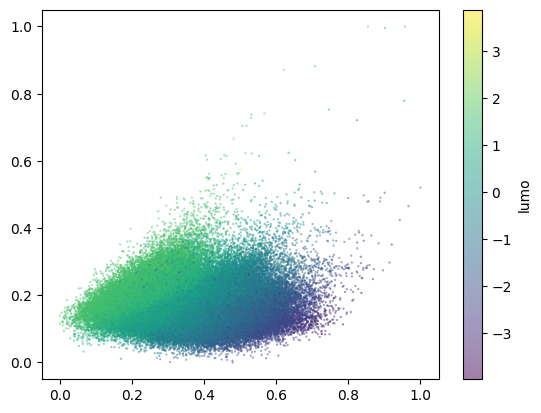

In [16]:
prop_opt = "lumo"

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# do pca and normalize
z_pca = PCA(n_components=2).fit_transform(z)
z_pca = MinMaxScaler().fit_transform(z_pca)

df = pd.DataFrame(np.transpose((z_pca[:,0],z_pca[:,1])))
df.columns = ['x','y']
df[prop_opt]=prop_df[prop_opt]

scatter = plt.scatter(x=df['x'], y=df['y'], c=df[prop_opt],
            cmap= 'viridis', marker='.',
            s=10,alpha=0.5, edgecolors='none')
plt.colorbar(scatter, label=prop_opt)
plt.show()

# Distribution

Decode Molecules in the neighborhood of the input molecule.

  0%|          | 0/32 [00:00<?, ?it/s]

Input SMILES: [H]C#C[C@@]([H])(C#N)OC(=O)N([H])[H]


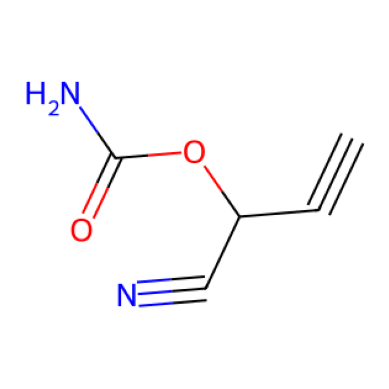

100%|██████████| 32/32 [00:00<00:00, 233.17it/s]

Decoded 22 valid molecules.
Decoded 13 unique molecules


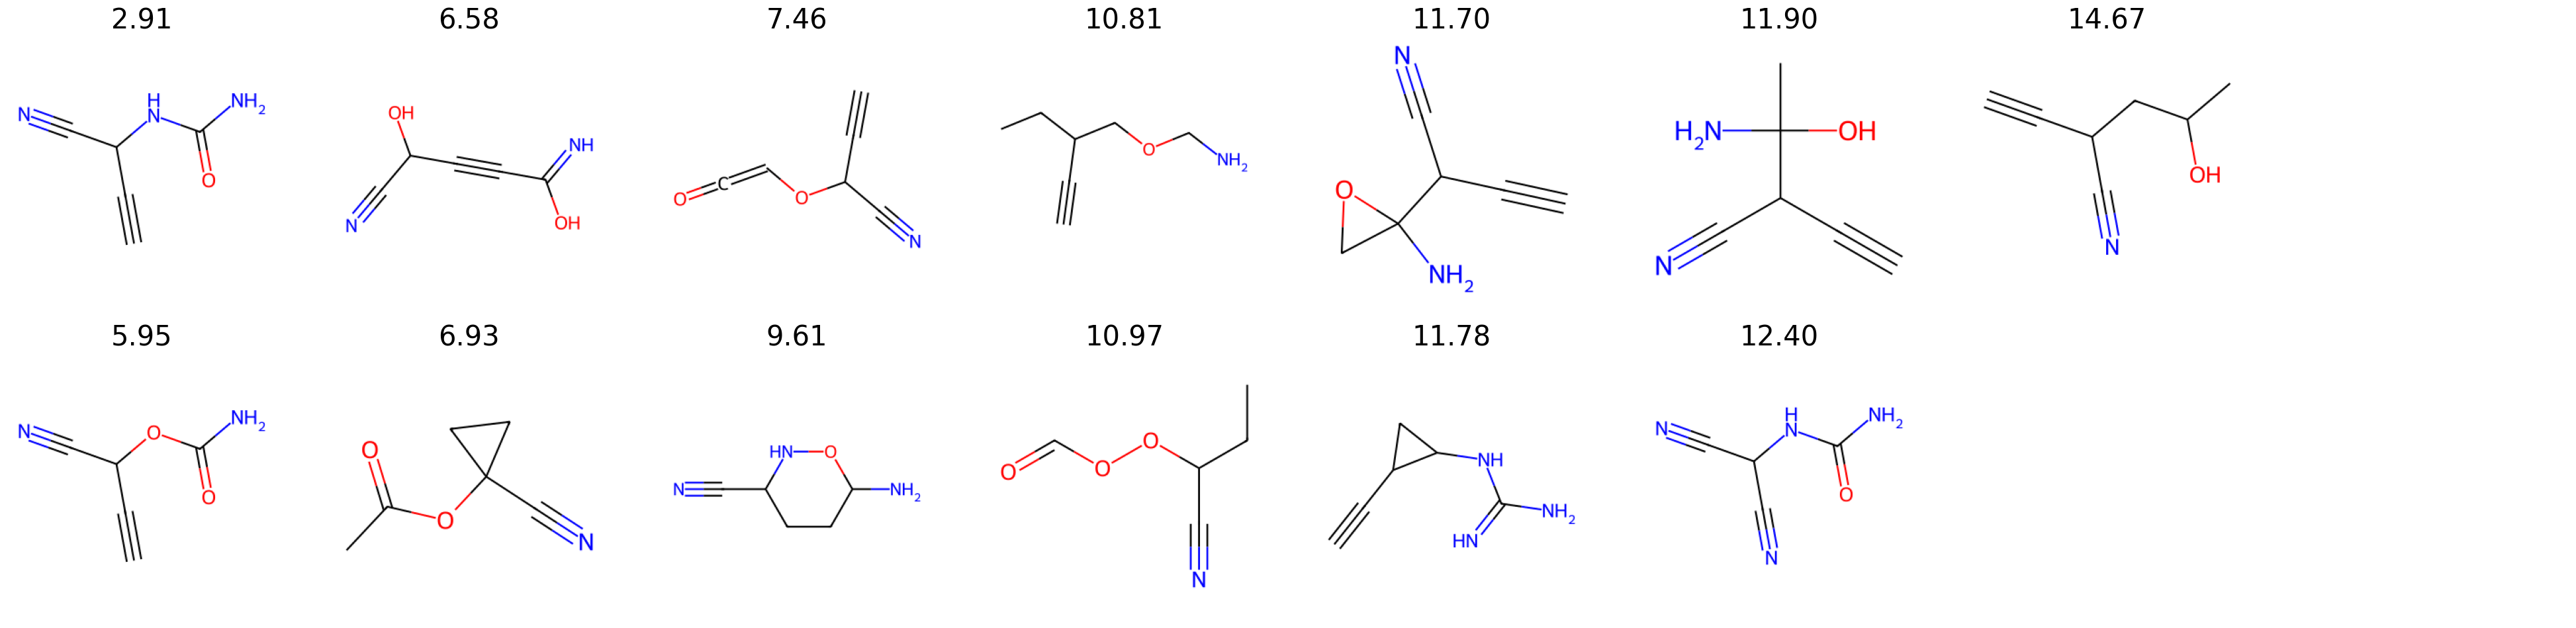

In [37]:
val_loader = dataloaders["val"]

#8, 190, 59, 101
mol_index = 59


input_mol_index = mol_index
decode_count = 32

decoded_mols = dict()
valid_count = 0

val_batch = next(iter(val_loader))
z = graph_vae_model.encode_mean(val_batch)[input_mol_index].unsqueeze(0)



for i in tqdm(range(decode_count)):
    with torch.no_grad():

        if i == 0:
            print(f"Input SMILES: {val_batch[input_mol_index].smiles}")

            input_mol = graph_to_mol(data=val_batch[input_mol_index], includes_h=include_hydrogen, validate=False)
            input_mol_img = mol_to_image_tensor(mol=input_mol).transpose(1, 3).transpose(1, 2)
            plt.imshow(input_mol_img[0])
            #plt.title("Input Molecule")
            plt.axis("off")
            plt.show()

        noise_vec = torch.randn_like(z, device=device)
        noise_vec_norm = noise_vec / torch.linalg.vector_norm(noise_vec)

        noise_scale = 16 * torch.rand(size=(1,), device=device)
        z_current = z + noise_vec_norm * noise_scale
        distance = torch.dist(z, z_current).item()
        val_recon = graph_vae_model.decode(z_current)
        
        x = (val_recon[0], val_recon[1], val_recon[2])
        recon_graph = graph_vae_model.output_to_graph(x=x, stochastic=False)

        if not nx.is_connected(pyg_utils.to_networkx(recon_graph, to_undirected=True)):
            continue

        try:
            recon_mol = graph_to_mol(data=recon_graph, includes_h=include_hydrogen, validate=True)
        except:
            continue

        valid_count += 1

        smiles = Chem.MolToSmiles(recon_mol)
        decoded_mols[smiles] = (recon_mol, distance)

print(f"Decoded {valid_count} valid molecules.")
print(f"Decoded {len(decoded_mols)} unique molecules")


num_mols = min(32, len(decoded_mols))

num_cols = min(8, num_mols)
num_rows = (num_mols + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 5))
fig.tight_layout(pad=3.0)

# Flatten the axes array for easy indexing
if num_mols > 1:
    axes = axes.flatten("F")
else:
    axes = [axes]

smiles_list = []
mol_list = []
distance_list = []
for smiles, (mol, distance) in decoded_mols.items():
    smiles_list.append(smiles)
    mol_list.append(mol)
    distance_list.append(distance)

df = pd.DataFrame({"smiles": smiles_list, "mol": mol_list, "distance": distance_list})
df.sort_values(by="distance", ascending=True, inplace=True)

for i, (index, row) in enumerate(df.head(num_mols).iterrows()):
    mol = row["mol"]
    distance = row["distance"]

    mol_img = mol_to_image_tensor(mol=mol).transpose(1, 3).transpose(1, 2)
    ax = axes[i]
    ax.imshow(mol_img[0])
    ax.set_title(f"{distance:.2f}", fontsize=30)
    ax.axis("off")


# # If the number of molecules is not a perfect fill for the subplot grid, hide the extra subplots
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.show()